In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Import necessary libraries
from sqlalchemy import create_engine, MetaData

# Create an engine to connect to the existing database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# Reflect the tables
metadata = MetaData()
metadata.reflect(bind=engine)

# Print the reflected table names
print(metadata.tables.keys())

dict_keys(['measurement', 'station'])


In [6]:
# Import necessary libraries
from sqlalchemy.ext.automap import automap_base

# Reflect the tables and create a Base object
Base = automap_base()
Base.prepare(engine, reflect=True)

# Print all of the classes found by automap
print(Base.classes.keys())

['measurement', 'station']


C:\Users\shrad\AppData\Local\Temp\ipykernel_2676\49005524.py:6: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# Save references to each table
# Assign references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Import the Session class
from sqlalchemy.orm import Session

# Create the session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
from sqlalchemy import func

# Query to find the most recent date
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print("The most recent date in the dataset is:", most_recent_date)

The most recent date in the dataset is: 2017-08-23


Date one year ago: 2016-08-23 00:00:00


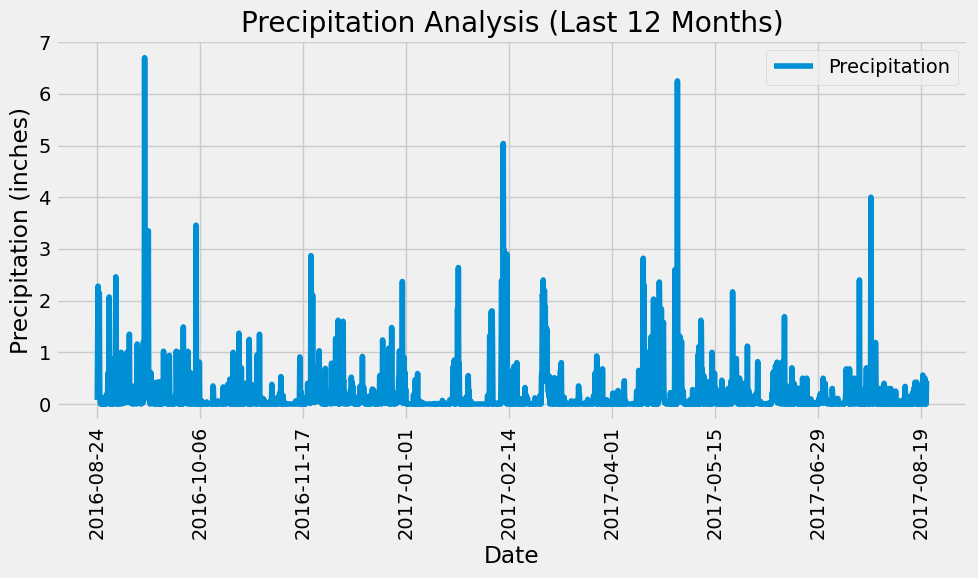

In [10]:
# Convert the most recent date to a datetime object
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year ago from the most recent date
one_year_ago = most_recent_date - dt.timedelta(days=365)
print("Date one year ago:", one_year_ago)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Load the query results into a Pandas DataFrame and set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Drop any NaN values
precipitation_df = precipitation_df.dropna()

# Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values('Date')

# Reset the index
precipitation_df = precipitation_df.reset_index(drop=True)

# Plot the data
precipitation_df.plot(x='Date', y='Precipitation', figsize=(10, 6), rot=90)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Analysis (Last 12 Months)')
plt.tight_layout()
plt.show()

In [11]:
# Calculate the summary statistics for the precipitation data
summary_stats = precipitation_df.describe()

print(summary_stats)

       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [12]:
from sqlalchemy import func

# Design a query to calculate the total number of stations
total_stations = session.query(func.count(Station.station)).scalar()

print("Total number of stations in the dataset:", total_stations)

Total number of stations in the dataset: 9


In [13]:
from sqlalchemy import desc

# Design a query to find the most active stations
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()

# Print the stations and their counts in descending order
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Get the most active station ID
most_active_station_id = most_active_stations[0][0]

# Design a query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_id).all()

# Print the results
print(f"Most Active Station ID: {most_active_station_id}")
print(f"Lowest Temperature: {temperature_stats[0][0]}")
print(f"Highest Temperature: {temperature_stats[0][1]}")
print(f"Average Temperature: {temperature_stats[0][2]}")

Most Active Station ID: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


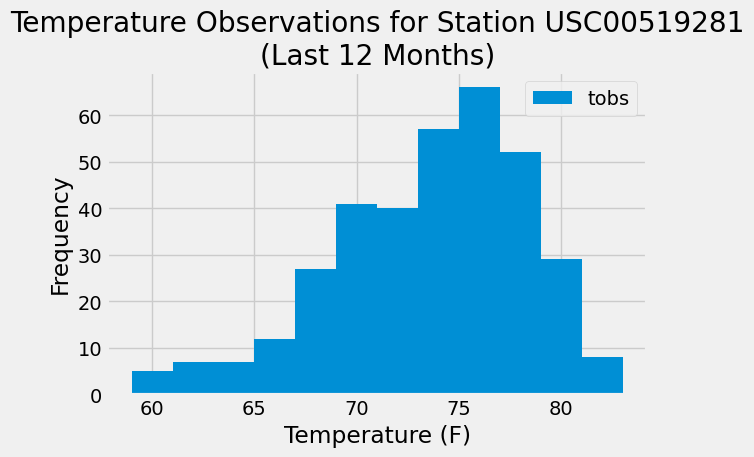

In [15]:
# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()

# Load the temperature data into a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

# Plot the temperature data as a histogram
plt.hist(temperature_df['Temperature'], bins=12, label='tobs')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station_id}\n(Last 12 Months)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()